In [1]:
from actorcritic import ActorCriticAgent, EnvironmentWrapper, Network
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn

## Without freezing 

In [2]:
# hyperparameters
config = {
    'experiment': 'Acrobot_MCC2CartPole',
    'device': 'cuda',
    'state_size': 6, 
    'action_size': 3,
    'hidden_sizes': [64, 64], 
    'lr_actor': 0.001,
    'lr_critic': 0.0005,
    'verbosity': 10,
    'env_name': 'CartPole-v1',
    'gamma': 0.99, 
    'reward_threshold': 475.0,
    'max_episodes': 2000,
    'max_steps': 500,
    'update_frequency': 500,
    'discrete': True

}


In [3]:
# Initialize the ActorCriticAgent
agent = ActorCriticAgent(config)

In [ ]:
# Modified Network class to accept additional inputs from source networks
class ProgressiveNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, source_networks=[], is_policy=True):
        super(ProgressiveNetwork, self).__init__()
        self.is_policy = is_policy
        self.source_networks = source_networks
        # Adjust the input size to include source networks' top hidden layer outputs
        adjusted_input_size = input_size + sum([hidden_sizes[-1] for _ in source_networks])  # Assumes the last hidden layer size is indicative

        # Building the layers
        layers = [nn.Linear(adjusted_input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.network = nn.Sequential(*layers)
        if is_policy:
            self.network.add_module("softmax", nn.Softmax(dim=-1))

    def forward(self, x):
        # Collect outputs from source network(s)
        source_outputs = [source.network[:-1](x).detach() for source in self.source_networks]  # Assumes source output is from the second last layer
        if source_outputs:
            x = torch.cat([x] + source_outputs, dim=1)
        
        return self.network(x)
    
# Function to load a model
def load_model(model_path, input_size=6, output_size=3, hidden_sizes=[64, 64], is_policy=True):
    model = Network(input_size, output_size, hidden_sizes, is_policy)
    model.load_state_dict(torch.load(model_path))
    return model

# Function to freeze a network
def freeze_network(network):
    for param in network.parameters():
        param.requires_grad = False

In [ ]:
# policy network
source_networks = [load_model('Acrobot-v1_policy_network.pth', output_size= 3, is_policy=True),
                   load_model('MountainCarContinuous-v0_policy_network.pth', output_size=3, is_policy=True)]

for net in source_networks:
    freeze_network(net)

target_network = ProgressiveNetwork(input_size=6, output_size=3,
                                    hidden_sizes=[64, 64], source_networks=source_networks, 
                                    is_policy=True)

agent.policy_network = target_network


In [ ]:
# policy network
source_networks = [load_model('Acrobot-v1_value_network.pth', output_size=1, is_policy=False),
                   load_model('MountainCarContinuous-v0_value_network.pth', output_size=1, is_policy=False)]

for net in source_networks:
    freeze_network(net)

target_network = ProgressiveNetwork(input_size=6, output_size=1,
                                    hidden_sizes=[64, 64], source_networks=source_networks, 
                                    is_policy=False)

agent.value_network = target_network

In [22]:
# Initialize the environment
env = gym.make(config['env_name'])

env_wrapper = EnvironmentWrapper(env)

In [23]:
results = agent.train(env_wrapper, max_episodes=config['max_episodes'], max_steps=config['max_steps'], reward_threshold=config['reward_threshold'], update_frequency=config['update_frequency'])

Episode 0, Avg Reward: 100.0, PLoss: -176.03294372558594, VLoss: 179.6963348388672
Episode 10, Avg Reward: -2.6636363636366784, PLoss: -347.7080993652344, VLoss: 433.1574401855469
Episode 20, Avg Reward: -3.809523809524149, PLoss: -499.9294738769531, VLoss: 570.659423828125
Episode 30, Avg Reward: -11.62903225806488, PLoss: -473.38214111328125, VLoss: 555.635498046875
Episode 40, Avg Reward: -6.5902439024393775, PLoss: -166.95118713378906, VLoss: 213.6312255859375
Episode 50, Avg Reward: -1.835294117647407, PLoss: -291.5284729003906, VLoss: 365.365966796875
Episode 60, Avg Reward: -0.9737704918036338, PLoss: -407.8578796386719, VLoss: 478.89447021484375
Episode 70, Avg Reward: -1.749295774648247, PLoss: -450.4147033691406, VLoss: 518.3145751953125
Episode 80, Avg Reward: 2.290123456789774, PLoss: -223.39183044433594, VLoss: 292.13409423828125
Episode 90, Avg Reward: 6.846153846153509, PLoss: -463.6004943847656, VLoss: 537.7360229492188
Episode 100, Avg Reward: 6.142999999999663, PLoss:

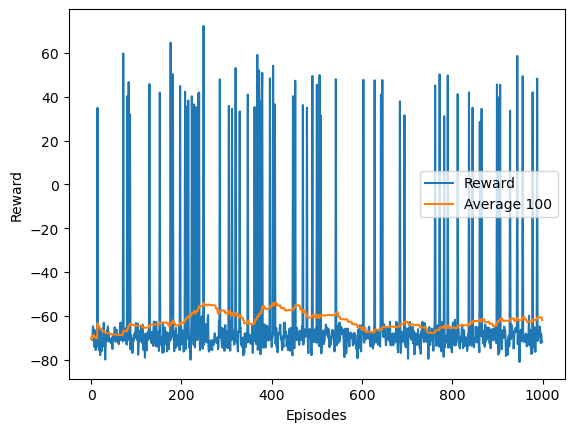

In [ ]:
# plot results
import matplotlib.pyplot as plt

plt.plot(results['Episode'], results['Reward'], label='Reward')
plt.plot(results['Episode'], results['Average_100'], label='Average 100')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()


In [ ]:
# save results with model name and time
np.save(f'results/{config['experiment']}', results)

In [ ]:
results['Duration']

1251.0735347270966